In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score, roc_curve
import gc
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 4, 4

def printmd(string):
    display(Markdown(string))

Загрузим датасет, разобьём на train 90%, test 10%.

In [100]:
def read(file='spambase.csv'):
    df = pd.read_csv(file)

    train = df.sample(frac=0.9)
    test  = df.drop(train.index)

    split = lambda df: (
        df.drop('label', axis=1).as_matrix(),
        df.label.as_matrix())
    global trainX, trainY, testX, testY
    trainX, trainY = split(train)
    testX, testY   = split(test)

### task 1

Реализуйте алгоритм Gaussian naive Bayes для датасета `spambase.csv`.

accuracy: 0.93478


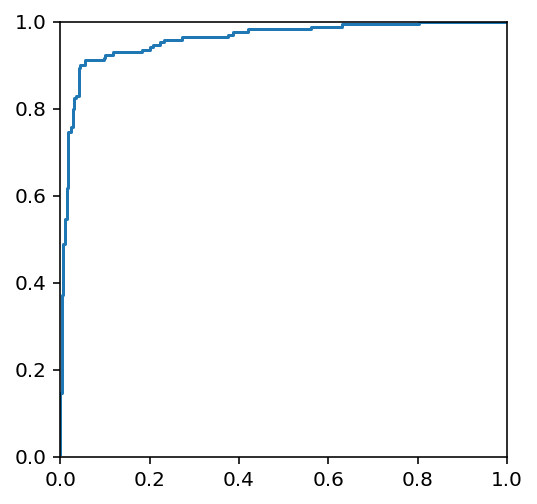

In [104]:
read('spambase.csv')

classes = np.unique(trainY)             # какие классы {y} есть
counts  = np.bincount(trainY)           # сколько объектов принадлежит классу {y}
probabs = np.log(counts / trainY.size)  # априорная вероятность класса {y}


do = lambda xs: [xs.mean(), xs.std()]
ds = np.array([[ do(trainX[trainY == y, f]) for f in range(trainX.shape[1])] for y in classes ])

res = probabs + np.zeros((testX.shape[0], classes.size))

for y in range(classes.size):
    for feature in range(trainX.shape[1]):
        xs        = testX.T[feature]
        mean, std = ds[y][feature]
        res.T[y] -= 0.5 * (xs - mean)**2 / (std**2 + 0.000001)

print(f'accuracy: {accuracy_score(testY, res.T[1] > res.T[0]):.5f}')
fpr, tpr, _ = roc_curve(testY, res.T[1] - res.T[0])
plt.plot(fpr, tpr); plt.xlim((0, 1)); plt.ylim((0, 1))
plt.show()

### task 2

Реализуйте алгоритм Multinomial naive Bayes для количества различных слов в датасете `smsspam.csv`.

accuracy: 0.87792


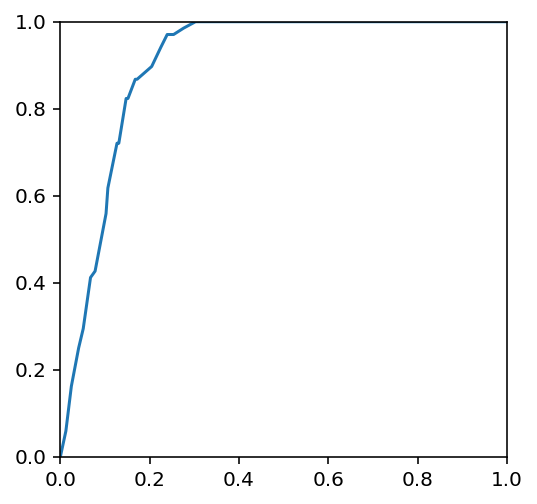

In [235]:
np.seterr(divide='ignore')
read('smsspam.csv')

trainX, trainY = df.drop('label', axis=1).as_matrix(), df.label.as_matrix()
trainY = trainY == 'spam'
testY  = testY  == 'spam'
                                             # количество различных слов в смс
trainX = np.apply_along_axis( lambda words: [len(set(words[0].split()))], 1, trainX )
testX  = np.apply_along_axis( lambda words: [len(set(words[0].split()))], 1, testX )

classes = np.unique(trainY)             # какие классы {y} есть
counts  = np.bincount(trainY)           # сколько объектов принадлежит классу {y}
probabs = np.log(counts / trainY.size)  # априорная вероятность класса {y}


do = lambda xs: [xs.mean(), xs.std()]
ds = np.array([[ do(trainX[trainY == y, f]) for f in range(trainX.shape[1])] for y in classes ])

res = probabs + np.zeros((testX.shape[0], classes.size))

for y in range(classes.size):
    for feature in range(trainX.shape[1]):
        xs        = testX.T[feature]
        mean, std = ds[y][feature]
        res.T[y] -= 0.5 * (xs - mean)**2 / (std**2 + 0.000001)

print(f'accuracy: {accuracy_score(testY, res.T[1] > res.T[0]):.5f}')
fpr, tpr, _ = roc_curve(testY, res.T[1] - res.T[0])
plt.plot(fpr, tpr); plt.xlim((0, 1)); plt.ylim((0, 1))
plt.show()